---
title: "Option Pricing with Neuron Network"
author: "Xipeng Du"
date: "2024-03-13"
categories: [option pricing, project]
---


## Introduction: Basic Idea of Option Pricing

Option is a financial contract that give the buyer the right to buy or sell certain quantity of assets as specific strike price on or before maturity date, and the buyer needs to pay premium or "option price" in this context to the seller of this contract. Option pricing is a way to evaluate the fair value of an option which corresponds to its striking price, maturity time and risk involved with the stock. Traditionally, traders use models like Black-Scholes model to estimate the price of an option, but these models have their limitations and base assumptions that are not certainly sound. With the power of machine learning, we are deriving a model that will evaluate the fair value of an option based on current stock price, quality, greeks of the stock, implied volatility of the stock. We will utilize pytorch to deploy a machine learning model to fit from past option price data for the S&P 500 index. 


## Data Acquisition

For the first step of our project is acquiring the data. We found a dataset [link] on kaggle, and traced to the source which is optiondx[link]. This websites contains a text based datasets with end of date data for free. The following is the features. Then, realizing we might need real time stock price data for target, we utilize a package called yfinance which calls yahoo finance's unofficial api to download data from a time range by `yf.download` function, which gets us an adjusted closed data at the end of each trading date. 

In [1]:
# getting stock prices for target evaluation
import pandas as pd
import yfinance as yf

target = pd.DataFrame(yf.download(['SPY'], start="2023-06-01", end="2023-12-31")['Adj Close'])
target

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2023-06-01,415.798767
2023-06-02,421.811676
2023-06-05,421.003418
2023-06-06,421.920135
2023-06-07,420.461212
...,...
2023-12-22,472.182892
2023-12-26,474.176697
2023-12-27,475.034058


 ## Data Cleaning

In [2]:
# importing neccessary packages
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sqlite3
import math

We have first removed all the contracts that are later than 2023 as a cutoff point which we will be unable to evaluate their target value at a future date. 

In [3]:
# Read in the data from Jan 2023 to May 2023
df_2023_h1 = pd.DataFrame()
for i in [202301, 202302, 202303, 202304,  202305]:
    df_2023_h1 = pd.concat([df_2023_h1, pd.read_table(f'data/spy_eod_{i}.txt', sep=',')], ignore_index=True)
df_2023_h1.columns = df_2023_h1.columns.str.strip()

# also drop expiration date later than 2024
df_2023_h1 = df_2023_h1[df_2023_h1['[EXPIRE_DATE]'] <= ' 2023-12-31']
df_2023_h1 = df_2023_h1[df_2023_h1['[EXPIRE_DATE]'] >= ' 2023-06-01']
df_2023_h1 = df_2023_h1.reset_index()

/var/folders/lc/cr1vnr593_l4t1814jghhy980000gn/T/ipykernel_98618/2066477931.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023_h1 = pd.concat([df_2023_h1, pd.read_table(f'data/spy_eod_{i}.txt', sep=',')], ignore_index=True)


We strip away all the spaces of the column names in this step for easier access, and removed the entries that target cannot be calculated. 

In [4]:
# change the string dates to datetime64
df_2023_h1['[QUOTE_DATE]'] = df_2023_h1['[QUOTE_DATE]'].apply(np.datetime64)
df_2023_h1['[EXPIRE_DATE]'] = df_2023_h1['[EXPIRE_DATE]'].apply(np.datetime64)

# merge our adj close stock data on EXPIRE_DATE
target['[EXPIRE_DATE]'] = target.index
target['[EXPIRE_DATE]'].astype('datetime64[ns]')

df_2023_h1 = pd.merge(df_2023_h1, target, on = '[EXPIRE_DATE]')


## Setting targets

Then, we have to set a target for our machine learning model. We first utilized a naive estimation of the option price, then start to focus on the intrinsic value of call option. with price = (K - S). 
<br>
Later, we set our target as intrinsic value of price based on payoff of call and put options, based on the function of discounted price = (K - S) * e^(-rt) where r is a risk free investment rate. 

In [5]:
from data_cleansing_function import target_setting
import inspect
print(inspect.getsource(target_setting))
df_2023_h1 = target_setting(df_2023_h1)
target = df_2023_h1['discounted_price']

def target_setting(df):
    """
    vectorized operation to calculate the target value based on formula
    """
    df['-rt'] = -0.04*(df['[EXPIRE_UNIX]'] - df['[QUOTE_UNIXTIME]'])/(3600*365*24)  # unix time is based on seconds
    df['price_diff'] = df['[STRIKE]'] - df['Adj Close']
    df['exp(-rt)'] = df['-rt'].apply(lambda x: math.exp(x))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]   
    df['discounted_price'] = df['price_diff'] * df['exp(-rt)']
    return df



We normalize all numerical columns with a standard scaler. 

In [6]:
df_2023_h1 = df_2023_h1[['[EXPIRE_UNIX]', '[QUOTE_DATE]', '[EXPIRE_DATE]', '[STRIKE]', '[UNDERLYING_LAST]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
       '[C_THETA]', '[C_RHO]', '[C_IV]', '[C_VOLUME]','[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]',
       '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]', '[P_ASK]', 'Adj Close']]

df_2023_h1 = df_2023_h1.replace(r'^\s*$', 0, regex=True)

# Basic normalization and standardization
# run block of code and catch warnings
import warnings
from sklearn.preprocessing import StandardScaler
with warnings.catch_warnings():
	# ignore all caught warnings
	warnings.filterwarnings("ignore")
	# execute code that will generate warnings
	numeric_cols = ['[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
       '[C_THETA]', '[C_RHO]', '[C_IV]', '[C_VOLUME]','[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]',
       '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]', '[P_ASK]']  # not sure about all this
	scaler = StandardScaler()
	df_2023_h1[numeric_cols] = scaler.fit_transform(df_2023_h1[numeric_cols])

In [7]:
target

0        -279.724554
1        -269.902630
2        -260.080706
3        -250.258782
4        -245.347819
             ...    
127485    -17.254494
127486    -12.346804
127487     -7.439115
127488     -2.531426
127489      2.376263
Name: discounted_price, Length: 127490, dtype: float64

Output the data to sqlite database. 

In [8]:
# output to sqlite database for others to use
conn = sqlite3.connect("data/tables.db")
df_2023_h1.to_sql("df_2023_h1_feature", conn, if_exists = "replace", index=False)
target.to_sql("df_2023_h1_target", conn, if_exists = "replace", index=False)
conn.close()


## Data Structures




## Baseline model: Linear Regression

We need to set a target for the neuron network to beat, if any model cannot beat a linear approximation of stock market in the long run it is a failure. 

In [9]:
# custom train test val split with a smaller dataset. 
# Read in the data from the database
conn = sqlite3.connect('data/tables.db')
# show database content
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
# Extract two tables from it and store them in two pd df
ds = pd.read_sql_query("SELECT * from df_2023_h1_feature", conn)
target = pd.read_sql_query("SELECT * from df_2023_h1_target", conn)

ds = ds.drop(['[QUOTE_DATE]', '[EXPIRE_DATE]', 'Adj Close'], axis=1)

X_train = ds[0:10000]
y_train = target[0:10000]
X_val = ds[10001:11001]
y_val = target[10001:11001]
X_test = ds[11002: 12002]
y_test = target[11002: 12002]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

[('df_2023_h1_feature',), ('df_2023_h1_target',)]
(10000, 21) (10000, 1) (1000, 21) (1000, 1) (1000, 21) (1000, 1)


In [10]:
target = pd.read_sql_query("SELECT * from df_2023_h1_target", conn)
target

,discounted_price
0,-279.724554
1,-269.902630
2,-260.080706
3,-250.258782
4,-245.347819
...,...
127485,-17.254494
127486,-12.346804
127487,-7.439115
127488,-2.531426


Utilizing a simple linear regression model from sklearn. 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

With this code block we can output a r2_list to check r2 and mse for a range of values for their relationship with the distance with train set, and output plot graphs. 

In [12]:
r2_list = []
mse_list = []
X_list = []
for i in range(10):
    X_test = ds.iloc[10000 + i * 10000:11000 + i * 10000]
    y_test = target.iloc[10000 + i * 10000:11000 + i * 10000]
    y_pred = reg.predict(X_test)
    X_list.append(10000 + i * 10000)
    r2_list.append(metrics.r2_score(y_true=y_test, y_pred=y_pred))
    mse_list.append(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred))

Text(0.5, 1.0, 'R2 Score for baseline model')

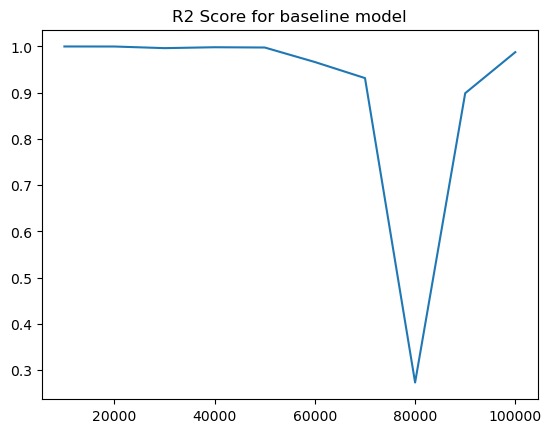

In [13]:
plt.plot(X_list, r2_list)
plt.title('R2 Score for baseline model')

Text(0.5, 1.0, 'MSE Loss for baseline model')

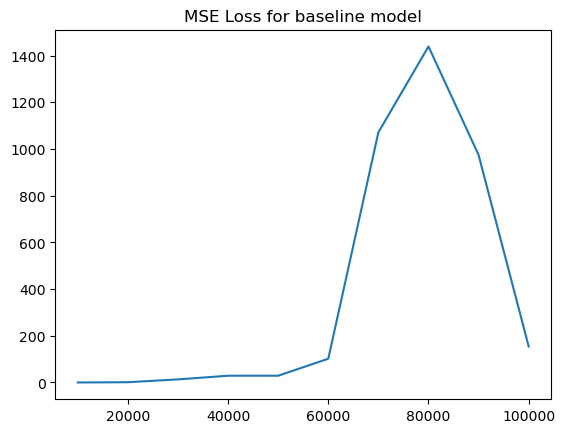

In [14]:
plt.plot(X_list, mse_list)
plt.title('MSE Loss for baseline model')

Linear regression model is not performing well after 80000 rows, which shows that the linear approximation of stock is not good enough for prediction further into the future. 